<a href="https://colab.research.google.com/github/TheBuilderHero/Deep_Learning_Road_Mapping/blob/main/Final_Project_OverFitting_Using_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import needed Libraries

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download and decompress Data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"thebuilderherokota","key":"705cf075e6b380effd0f2494d5e39123"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

deepglobe-road-extraction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip

replace class_dict.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls -l

total 3980196
-rw-r--r-- 1 root root         46 Nov 10  2020  class_dict.csv
-rw-r--r-- 1 root root 4074676823 Nov 10  2020  deepglobe-road-extraction-dataset.zip
-rw-r--r-- 1 root root         74 Apr 13 05:39 'kaggle (1).json'
-rw-r--r-- 1 root root         74 Apr 13 05:24  kaggle.json
-rw-r--r-- 1 root root     434416 Nov 10  2020  metadata.csv
drwxr-xr-x 1 root root       4096 Apr 11 13:21  sample_data
drwxr-xr-x 2 root root      40960 Apr 13 05:27  test
drwxr-xr-x 2 root root     495616 Apr 13 05:27  train
drwxr-xr-x 2 root root      45056 Apr 13 05:28  valid


In [ ]:
#!ls -l test

In [ ]:
#!ls -l valid

In [ ]:
#!ls -l train

## Update file architechture

In [ ]:
!cp /content/train/* /content/trainingdata/

cp: target '/content/trainingdata/' is not a directory


## Get min size information associated with picture data

In [ ]:
from PIL import Image
filenames = []
sizes = []
index=1

# This is my path
paths = ["test", "valid", "train"]

# dirs=directories
for path in paths:
  for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.jpg' in f:
            filenames.append(f)
            filename = root + "/" + f
            sizes.append([Image.open(filename, 'r').size,index])
            index += 1


print(sizes)
print(max(sizes))
print(min(sizes))

# Define the target size
value = min(sizes)
print(value[0])
target_size = value[0]  # Specify the new width and height

[[(1024, 1024), 1], [(1024, 1024), 2], [(1024, 1024), 3], [(1024, 1024), 4], [(1024, 1024), 5], [(1024, 1024), 6], [(1024, 1024), 7], [(1024, 1024), 8], [(1024, 1024), 9], [(1024, 1024), 10], [(1024, 1024), 11], [(1024, 1024), 12], [(1024, 1024), 13], [(1024, 1024), 14], [(1024, 1024), 15], [(1024, 1024), 16], [(1024, 1024), 17], [(1024, 1024), 18], [(1024, 1024), 19], [(1024, 1024), 20], [(1024, 1024), 21], [(1024, 1024), 22], [(1024, 1024), 23], [(1024, 1024), 24], [(1024, 1024), 25], [(1024, 1024), 26], [(1024, 1024), 27], [(1024, 1024), 28], [(1024, 1024), 29], [(1024, 1024), 30], [(1024, 1024), 31], [(1024, 1024), 32], [(1024, 1024), 33], [(1024, 1024), 34], [(1024, 1024), 35], [(1024, 1024), 36], [(1024, 1024), 37], [(1024, 1024), 38], [(1024, 1024), 39], [(1024, 1024), 40], [(1024, 1024), 41], [(1024, 1024), 42], [(1024, 1024), 43], [(1024, 1024), 44], [(1024, 1024), 45], [(1024, 1024), 46], [(1024, 1024), 47], [(1024, 1024), 48], [(1024, 1024), 49], [(1024, 1024), 50], [(1024, 

## Load image data and Rescale pictures to smallest picture size

In [ ]:
#!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-ubcq5f8r
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-ubcq5f8r
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done


In [ ]:
# this loads gets all the file names for both the pictures and their masks and puts them into a dataframe.
metadata_df = pd.read_csv(os.path.join("./", 'metadata.csv'))
class_df = pd.read_csv(os.path.join("./", 'class_dict.csv'))
metadata_train_df = metadata_df[metadata_df["split"] == "train"]
metadata_test_df = metadata_df[metadata_df["split"] == "test"]

#remove the plit column now that it is not needed:
metadata_train_df.drop("split",inplace=True,axis=1)
metadata_test_df.drop("split",inplace=True,axis=1)

#test does not need the mask path since it is gonna generate them:
metadata_test_df.drop("mask_path",inplace=True,axis=1)

#fix indexing:
metadata_train_df = metadata_train_df.reset_index()
metadata_test_df = metadata_test_df.reset_index()

#metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]

# get full path to the images
metadata_train_df['sat_image_path'] = metadata_train_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_train_df['mask_path'] = metadata_train_df['mask_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_test_df['sat_image_path'] = metadata_test_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))

#### Shuffle and split data

In [1]:
metadata_train_df = metadata_train_df.sample(frac=1).reset_index(drop=True)

NameError: name 'metadata_train_df' is not defined

In [ ]:
valid_df = metadata_train_df.sample(frac=0.2,random_state=42)
train_df = metadata_train_df.drop(valid_df.index)

#### Get class data

In [ ]:
class_names = class_df["name"].tolist()

In [ ]:
RGB_values = class_df[["r","g","b"]].values.tolist()

In [ ]:
Class_Type = ['background', 'road']

In [ ]:
# Makes the class values 0 and 1
Class_Indices = [class_names.index(cls.lower()) for cls in Class_Type]

In [2]:
Class_RGB_Values = np.array(RGB_values)[Class_Indices]
# Creates a matrix of class RGB values

NameError: name 'np' is not defined

## Image Loading and Processing

In [ ]:
import cv2
import pandas as pd
import tensorflow as tf

# Function to read images
def read_images(row):
    sat_image_path = row['sat_image_path']
    mask_path = row['mask_path']
    return [cv2.imread(sat_image_path), cv2.imread(mask_path)]

# Apply the function to each row of the DataFrame
image_df = metadata_df.apply(read_images, axis=1, result_type='expand')

# Rename columns
image_df.columns = ['sat_image', 'mask']

image_df.head()

NameError: name 'metadata_df' is not defined

In [ ]:
# Note code is from: https://www.kaggle.com/code/balraj98/road-extraction-from-satellite-images-deeplabv3
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [ ]:
# Note code is from: https://www.kaggle.com/code/balraj98/road-extraction-from-satellite-images-deeplabv3
class_dict = pd.read_csv(os.path.join("./", 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

In [ ]:


n_classes = len(class_names)

image_df['mask'] = tf.one_hot(image_df['mask'], n_classes)

image_df.head()

Move all Data items into working folder.

## Create class to hold image data for training.

In [ ]:
# Note code is from: https://www.kaggle.com/code/balraj98/road-extraction-from-satellite-images-deeplabv3
import torch
import cv2
class RoadsDataset(torch.utils.data.Dataset):

    """DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

## Load data into training and testing sets

### Start by splitting and shuffling the data

In [ ]:
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Split the data 80 for training and 20 for testing
valid_df = metadata_df.sample(frac=0.2, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)
#metadata_df.head()

(4981, 1245)

Image shape: (1024, 1024, 3), Mask shape: (1024, 1024, 2)


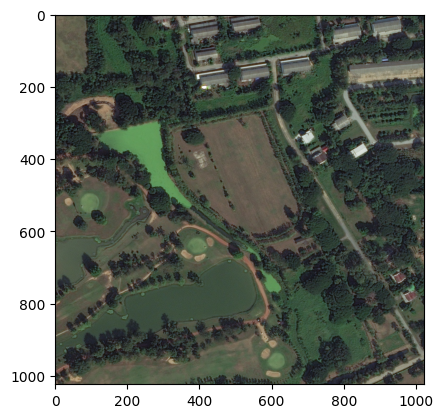

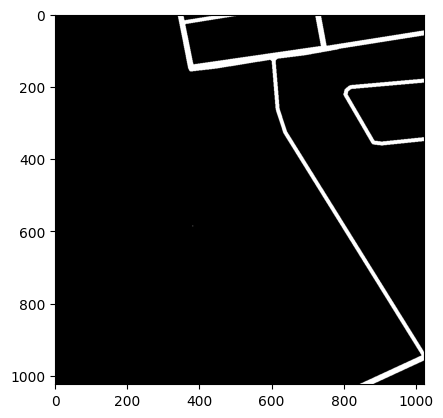

In [ ]:
import random
# Setup the dataset # Note that the class_rgb_values is being set to the RGB values of the input classes values.
dataset = RoadsDataset(train_df, class_rgb_values=np.array(class_rgb_values)[[class_names.index(cls.lower()) for cls in class_names]])
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx] # get some random sample
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
mask_single_channel = mask[:, :, 0]
plt.imshow(mask_single_channel, cmap='gray')
plt.show()

#plt.imshow(mask)
#plt.show()

### Now using the RoadsDataset class we create datasets for both training and validation

In [ ]:
import tensorflow as tf

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


image, mask = dataset[random_idx]
print(image.shape, mask.shape)
image, mask = normalize(image, mask)
print(image.shape, mask.shape)


(1024, 1024, 3) (1024, 1024, 2)
(1024, 1024, 3) (1024, 1024, 2)


## Build the model

In [ ]:
model = Sequential()
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape = (target_size[0],target_size[1],3), padding='same' ))
print(model.output_shape)
print(model.input_shape)
model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu' , padding='same') )
model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 8, ( 2, 2 ), activation = 'relu', padding='same' ) )
model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 8, ( 2, 2 ), activation = 'relu', padding='same' ) )
model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
model.add( Conv2D( 8, ( 2, 2 ), activation = 'relu', padding='same' ) )
#model.add( MaxPool2D(2, 2) )
#model.add(Dropout(0.10))
#model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', padding='same' ) )
model.add( Flatten() )
model.add( Dense( 128, activation = 'relu' ) )
model.add( Dense( 2, activation = 'sigmoid' ) )

(None, 1024, 1024, 16)
(None, 1024, 1024, 3)


In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the filepath for saving the weights
#filepath = "model_weights.h5"

# Load the saved weights into the model
#model.load_weights("model_weights.h5")

# Define a ModelCheckpoint callback to save the weights
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

## Compile the model and overfit it to the Data

In [ ]:
model.compile( optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [ 'accuracy' ] )
model.summary()
# Train using the training set and evaluate using the validation set
#Removed :: validation_data = valid_generator, and , callbacks=[checkpoint]

#train_generator_one_hot.element_spec
history = model.fit( new_image_df,  epochs = 200)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 512, 512, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 512, 8)       1160      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 256, 256, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 8)       264       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 8)      

ValueError: Failed to find data adapter that can handle input: <class '__main__.RoadsDataset'>, <class 'NoneType'>

## Convert to HTML this notebook

In [ ]:
%%shell
jupyter nbconvert --to html /content/TestProject_OverFitting_AllData.ipynb